In [2]:
#using pandas for all data operations
import pandas as pd

#column headers
headers = ['class',
           'alcohol',
           'malic_acid',
           'ash',
           'alcanicity_of_ash',
           'magnesium',
           'total_phenols',
           'flavanoids',
           'nonflavanoid_phenols',
           'proanthocyanins',
           'colour_intensity',
           'hue',
           '0D280_0D315_of_diluted_wines',
           'proline']

#can be read using pd.read_fwf as well but requires specifying the delimiter
data = pd.read_csv("wine.data", names=headers)

data.shape

(178, 14)

In [3]:
results_all = pd.read_csv('results_table_all.csv')

In [4]:
#data listed as having no null values, still double checking
data = data.dropna()
data.shape

(178, 14)

In [5]:
#checking and dropping duplicates as well, no change
data = data.drop_duplicates()
data.shape

(178, 14)

In [6]:
#replacing class labels so they start from 0 instead of 1 - fixes pytorch target out of bounds error
class_replace = {1:0, 2:1, 3:2}
data['class'] = data['class'].map(class_replace)

data.head()

,class,alcohol,malic_acid,ash,alcanicity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,colour_intensity,hue,0D280_0D315_of_diluted_wines,proline
0,0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,0,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,0,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,0,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
#data standardization using z-score normalisation. mean=0, std=1 (default)
from sklearn.preprocessing import StandardScaler

classes = pd.DataFrame(data['class'])
classless_data = data.drop(columns=['class'])

scaler = StandardScaler()
normalised_data = pd.DataFrame(scaler.fit_transform(data), columns=headers)

normalised_data = pd.DataFrame(normalised_data, columns=classless_data.columns)
normalised_data = classes.merge(normalised_data, how='cross')
normalised_data.head()

,class,alcohol,malic_acid,ash,alcanicity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,colour_intensity,hue,0D280_0D315_of_diluted_wines,proline
0,0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,0,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


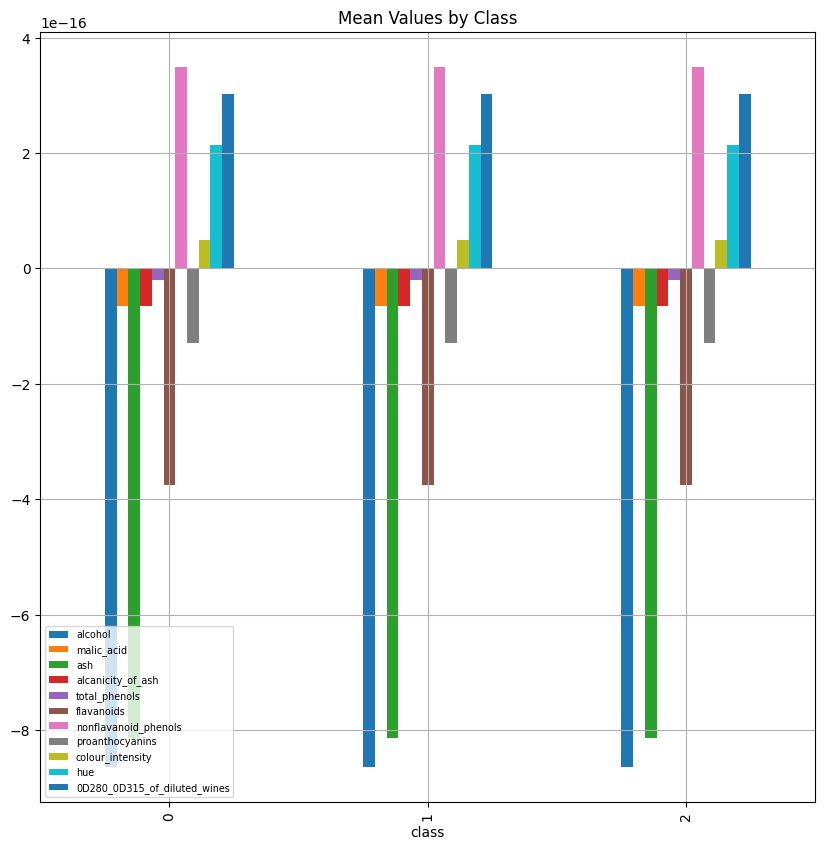

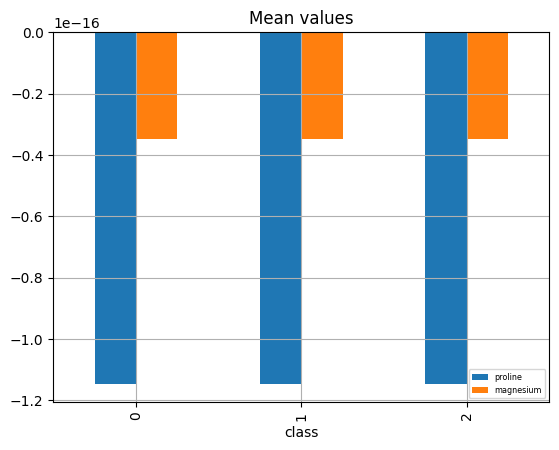

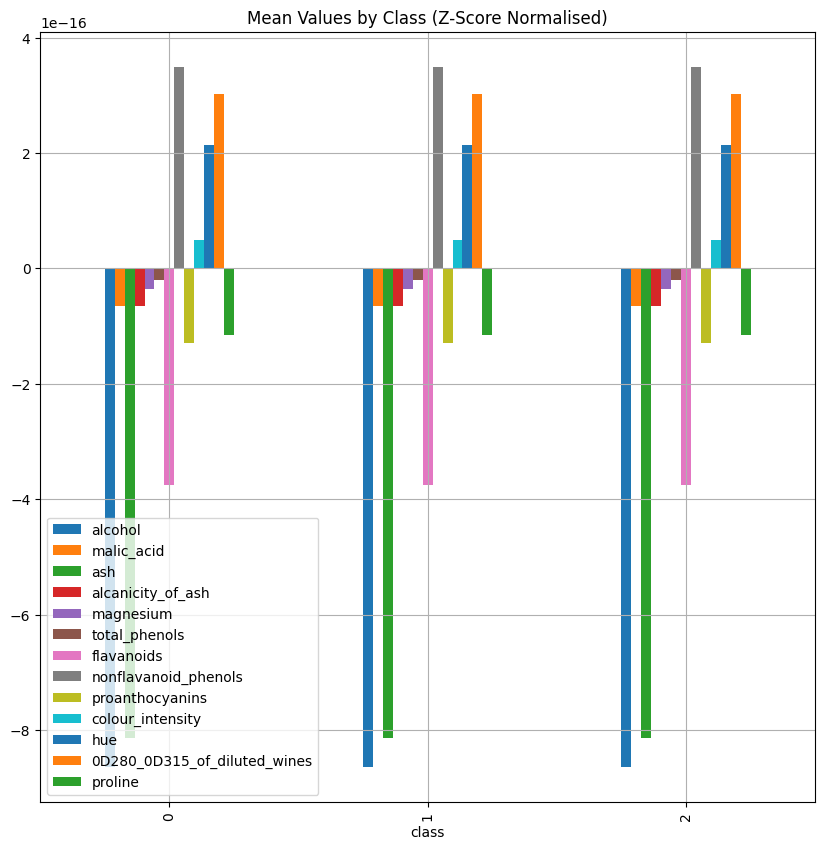

In [8]:
import matplotlib.pyplot as plt

#groupby class, creating mean for all classes 
data_by_class = normalised_data.groupby('class', as_index=True).mean()

data_by_class_no_proline_magnesium = data_by_class.drop(columns=['proline','magnesium']) 
data_by_class_proline_magnesium = data_by_class[['proline','magnesium']]

#visualising means for normalised data
data_by_class_no_proline_magnesium.plot(kind='bar', grid=True, title='Mean Values by Class', figsize=(10,10)).legend(loc='best',fontsize='x-small') 
data_by_class_proline_magnesium.plot(kind='bar', grid=True, title='Mean values').legend(loc='best',fontsize='xx-small') 
data_by_class.plot(kind='bar', grid=True, title='Mean Values by Class (Z-Score Normalised)', figsize=(10,10)).legend(loc='best') 
plt.show()

In [9]:
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

#removing class values for training
X = data.drop(columns=["class"]).values
Y = data["class"].values

#data standardization using z-score normalisation (default mean/std)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#defining unscaled and scaled test/train splits for baseline testing, these are redefined in the MLP training loop
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=451) #this split is used for random forest
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_scaled, Y, test_size=0.20, random_state=451) 

In [10]:
#random forest classifier for base, SMOTE, and feature selection versions

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

#for the classification report
classes = ["Class 1", "Class 2", "Class 3"]

#rf implementation without selected features
rf_num_tests = 10

rf_trees = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 28, 35, 42, 100, 200, 500, 1000]

rf_results = []
rf_reports = []
rf_selected_reports =[]

#use this for training the RF
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=451)

for tree_count in rf_trees:
    for _ in range(rf_num_tests):
        
        #uncomment for SMOTE training
        #synthesis = SMOTE(random_state=451)
        #X_train_synth, Y_train_synth = synthesis.fit_resample(X_train, Y_train)
        
        wine_rf_classifier = RandomForestClassifier(n_estimators=tree_count, random_state=451)
        #wine_rf_classifier.fit(X_train_synth, Y_train_synth)
        wine_rf_classifier.fit(X_train, Y_train)
        pred = wine_rf_classifier.predict(X_test)
                
        rf_overall = classification_report(Y_test, pred, target_names=classes, output_dict=True)
        rf_overall['Trees'] = tree_count
        rf_accuracy = accuracy_score(Y_test, pred)
        #print("Random Forest accuracy: ", rf_accuracy, '\n')
        
        rf_reports.append(rf_overall)
        rf_results.append((tree_count, rf_accuracy))

rf_report = pd.DataFrame(rf_reports).transpose()
rf_results_base = pd.DataFrame(rf_results, columns=['Trees', 'OA'])
rf_results_base.to_csv('rf_results_base.csv')
rf_report.to_csv('rf_report_base.csv')
        
#rf implementation with selected features
feature_importances = wine_rf_classifier.feature_importances_
importance_df = pd.DataFrame((feature_importances, classless_data.columns))

#threshold for feature importance
threshold = 0.05

selected_features = [feature for idx, feature in enumerate(range(X_train.shape[1])) if feature_importances[idx] >= threshold]

#filtering train/test to just the selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

rf_selected_results = []

for tree_count in rf_trees:
    for _ in range(rf_num_tests):

        #train a new rf model using the selected features
        wine_rf_model_selected = RandomForestClassifier(n_estimators=tree_count, random_state=451)
        wine_rf_model_selected.fit(X_train_selected, Y_train)
        pred_selected = wine_rf_model_selected.predict(X_test_selected)
        
        rf_overall_selected = classification_report(Y_test, pred_selected, target_names=classes, output_dict=True)
        rf_overall_selected['Trees'] = tree_count
        rf_selected_accuracy = accuracy_score(Y_test, pred_selected)
        #print("Random Forest selected accuracy: ", rf_selected_accuracy)
        
        rf_selected_reports.append(rf_overall_selected)
        rf_selected_results.append((tree_count, rf_selected_accuracy))

rf_selected_report = pd.DataFrame(rf_selected_reports).transpose()    
rf_selected_results = pd.DataFrame(rf_selected_results, columns=['Trees', 'OA'])
rf_selected_results.to_csv('rf_selected_results.csv')
rf_selected_report.to_csv('rf_selected_report.csv')

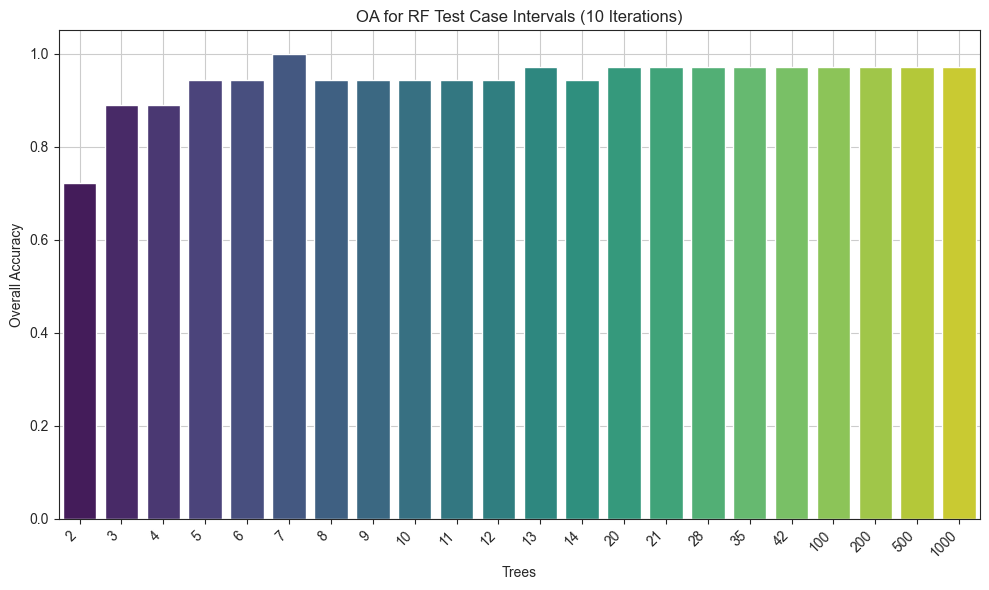

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#visualising the results table
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.barplot(x='Trees', y="OA", data=rf_results_base, palette="viridis")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Trees")
plt.ylabel("Overall Accuracy")
plt.title("OA for RF Test Case Intervals (10 Iterations)")
plt.tight_layout()
plt.show()

In [12]:
#just double checking the selected features
selected_feature_names = ['alcohol','total_phenols','flavanoids','colour_intensity','hue','0D280_0d315_of_diluted_wines','proline']
selected_features_list = list(zip(selected_feature_names, selected_features))

selected_features_list

[('alcohol', 0),
 ('total_phenols', 5),
 ('flavanoids', 6),
 ('colour_intensity', 9),
 ('hue', 10),
 ('0D280_0d315_of_diluted_wines', 11),
 ('proline', 12)]

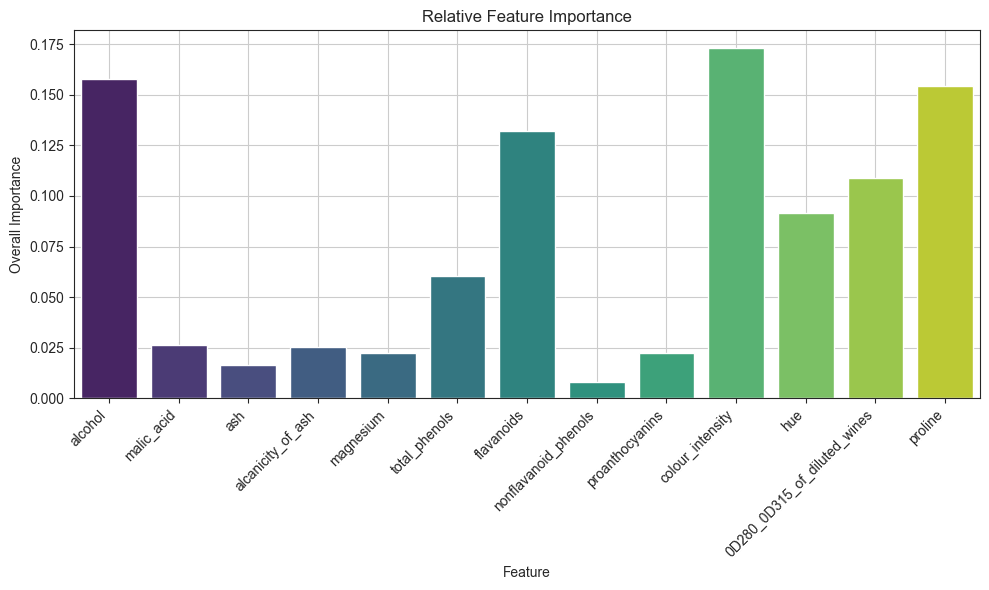

In [13]:
importance_df = pd.DataFrame(importance_df.transpose())
importance_df.columns = ['Importance', 'Feature']
importance_df.head()

#visualising the feature importances table
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.barplot(x='Feature', y="Importance", data=importance_df, palette="viridis")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Overall Importance")
plt.title("Relative Feature Importance")
plt.tight_layout()
plt.show()

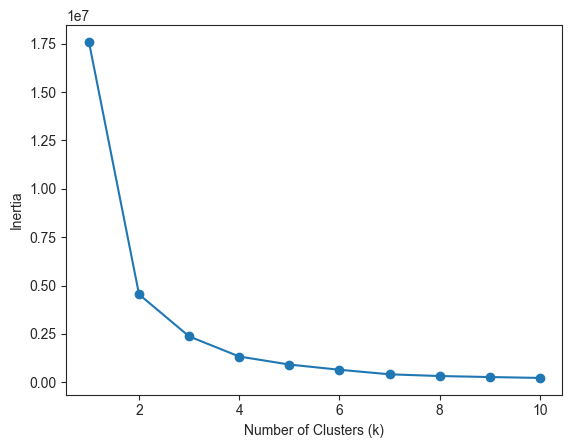

Index(['alcohol', 'malic_acid', 'ash', 'alcanicity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'colour_intensity', 'hue',
       '0D280_0D315_of_diluted_wines', 'proline'],
      dtype='object')


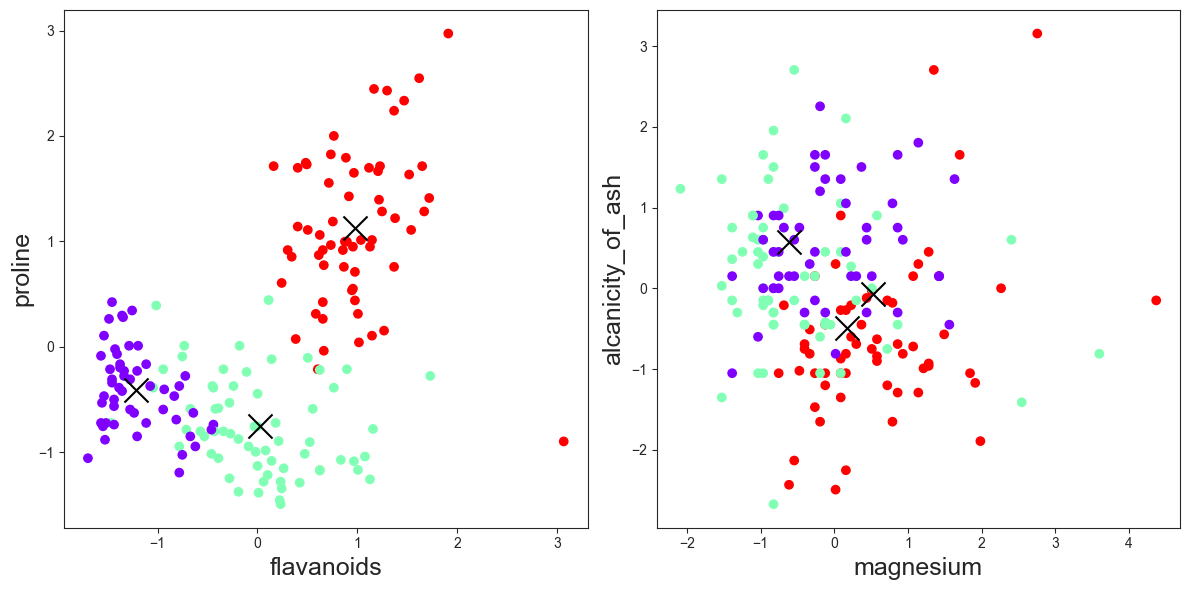

In [14]:
#data clustering for evaluation using standard k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#removing unneeded warning output
import warnings
warnings.filterwarnings("ignore") 

#calculating elbow for data
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(classless_data)
    inertia.append(kmeans.inertia_)

#elbow curve plot
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

#defining here to change for all
wine_clusters = 3

#keeping variables separate for x,y split later on
k_normalised_data = pd.DataFrame(scaler.fit_transform(classless_data), columns=headers[1:])

print(k_normalised_data.columns)

kmeans = KMeans(n_clusters=wine_clusters)
kmeans.fit(k_normalised_data)

#highest and lowest importance features identified by random forest feature selection
first = 'flavanoids'
second = 'proline'
penult = 'magnesium'
ult = 'alcanicity_of_ash'

top_two = k_normalised_data[[first, second]]
bottom_two = k_normalised_data[[penult, ult]]

importance_labels_kmeans = kmeans.predict(k_normalised_data)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(top_two[first], top_two[second], c=importance_labels_kmeans, cmap='rainbow')
axes[0].scatter(kmeans.cluster_centers_[:, 6], kmeans.cluster_centers_[:, 12], marker='x', s=300, c='black')
axes[0].set_xlabel(first, fontsize='18')
axes[0].set_ylabel(second, fontsize='18')

axes[1].scatter(bottom_two[penult], bottom_two[ult], c=importance_labels_kmeans, cmap='rainbow')
axes[1].scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], marker='x', s=300, c='black')
axes[1].set_xlabel(penult, fontsize='18')
axes[1].set_ylabel(ult, fontsize='18')

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

#defining the multilayer perceptron model layers and forward function (output of model based on input data)
class MLP(nn.Module):
    
    #using fully connected layers and a softmax function - assigning these to the class for the training loop
    def __init__(self, tensor_shape):
        super(MLP, self).__init__()
        self.tensor_shape = tensor_shape.shape[1]
        self.fc1 = nn.Linear(self.tensor_shape, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.softmax = nn.Softmax(dim=1)
    
    #ReLU is a fast activation function and adresses the vanishing gradient problem
    def forward(self, x): 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [16]:
#multi-train for the MLP

def calculate_metrics(y_true, y_pred, test_accuracy):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    accuracy = test_accuracy
    
    return {
        "False Positives": fp,
        "False Negatives": fn,
        "Overall Accuracy": accuracy
    }

#loss and val loss generally flatten out at about 1000 epochs with lr=1e-3 without normalisation and 200 with
epochs = 1500

#iterates n times over each variable
num_tests = 1

test_ratios = [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.50, 0.20, 0.15, 0.10, 0.05]
learn_rates = [0.001, 0.0001, 0.00001, 0.000001]

results = [] #for seaborn plotting
metrics_results = [] #for results table

#for feature selection, insert below to use
X_selected = X_scaled[:, selected_features]

train_losses = []
val_losses = []

#main training loop for all test ratios or 
for learn_rate in learn_rates:
    for _ in range(num_tests):
        
        
        #test_size=test_ratio for split tests in train_test_split or learn_rate=learn_rate for learn rate tests in Adam
        X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=451) #arbitrary Ray Bradbury for consistent test/train split :)
        X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=451)        
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        Y_train_tensor = torch.tensor(Y_train, dtype=torch.int64)

        #X_test_tensor used for labelling
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

        #defining the model in the loop so parameters aren't reused
        wine_model = MLP(tensor_shape=X_train_tensor)
        
        #defining the optimiser and loss function - cross-entropy used here for multi-class with Adam or AdamW
        optimiser = optim.AdamW(wine_model.parameters(), lr=learn_rate, weight_decay=0.01)
        loss_func = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            wine_model.train()
            optimiser.zero_grad()

            outputs = wine_model(X_train_tensor)
            loss = loss_func(outputs, Y_train_tensor)
            test_accuracy = accuracy_score(Y_train_tensor, torch.argmax(outputs, dim=1))
            train_losses.append((learn_rate, epoch, loss.item(), test_accuracy))
            loss.backward()
            optimiser.step()

            wine_model.eval()
            with torch.no_grad():
                outputs = wine_model(torch.tensor(X_val, dtype=torch.float32))
                val_loss = loss_func(outputs, torch.tensor(Y_val, dtype=torch.int64))
                val_accuracy = accuracy_score(Y_val, torch.argmax(outputs, dim=1))
                val_losses.append((learn_rate, epoch, val_loss.item(), val_accuracy))
                
        wine_model.eval()
        '''
        #checking for model parameter leakage
        for param in wine_model.parameters():
            param_data = param.data.detach().numpy()
            print(sum(param_data), '\n')
        '''
        with torch.no_grad():
            test_predictions = wine_model(torch.tensor(X_test, dtype=torch.float32))
            test_accuracy = accuracy_score(Y_test, torch.argmax(test_predictions, dim=1))
            
            metrics = calculate_metrics(Y_test, torch.argmax(test_predictions, dim=1), test_accuracy)
            metrics["Learn Rate"] = learn_rate
            metrics["Train Data Size"] = len(X_train)

            metrics_results.append(metrics)
            results.append({"Learn Rate": learn_rate, "Accuracy": test_accuracy})
        

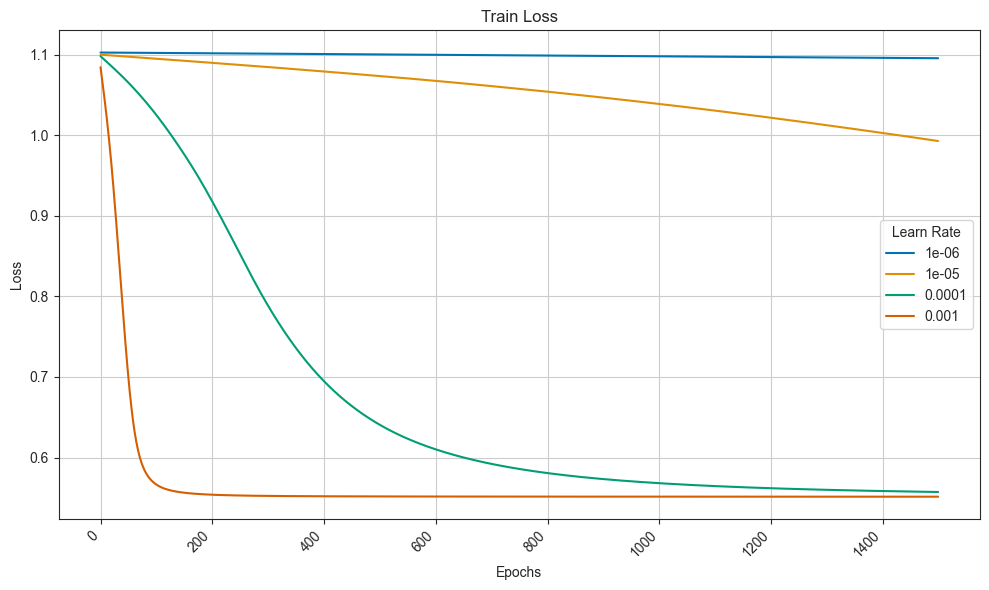

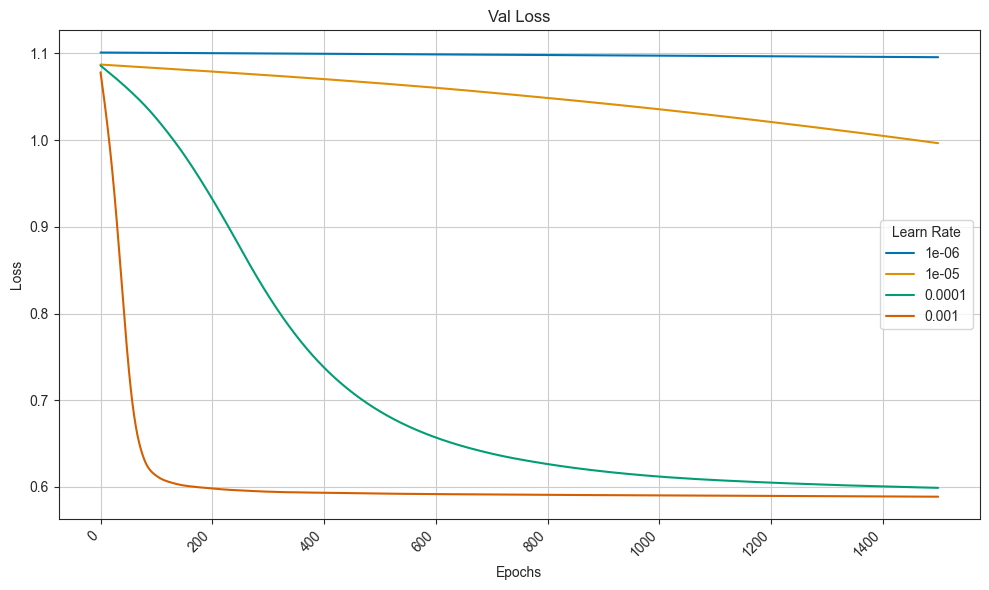

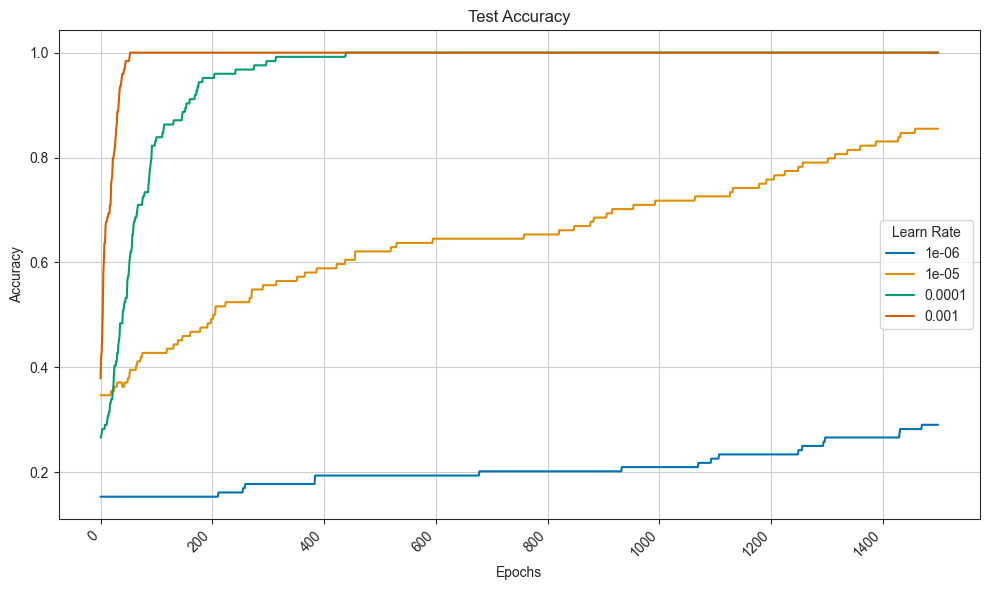

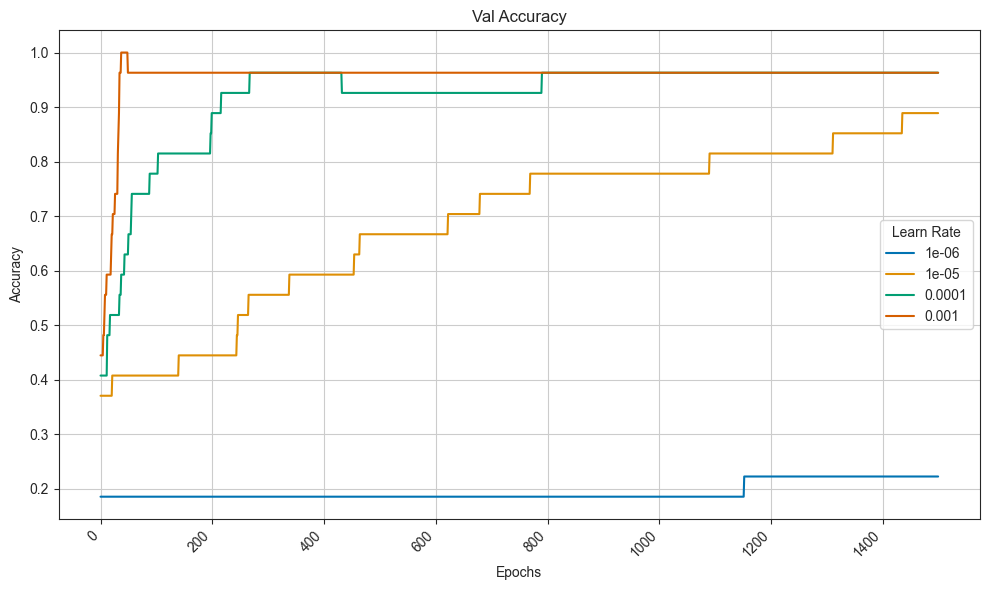

In [17]:
#visualising results for num_tests=1 - not subplots so each can be saved for display

train_losses_viz = pd.DataFrame(data=train_losses, columns=['Learn Rate', 'Epoch', 'Loss', 'Accuracy'])
val_losses_viz = pd.DataFrame(data=val_losses, columns=['Learn Rate', 'Epoch', 'Loss', 'Accuracy'])

plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.lineplot(x='Epoch', y="Loss", data=train_losses_viz, hue='Learn Rate', palette="colorblind")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.lineplot(x='Epoch', y="Loss", data=val_losses_viz, hue='Learn Rate', palette="colorblind")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Val Loss")
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.lineplot(x='Epoch', y="Accuracy", data=train_losses_viz, hue='Learn Rate', palette="colorblind")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.tight_layout()

plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.lineplot(x='Epoch', y="Accuracy", data=val_losses_viz, hue='Learn Rate', palette="colorblind")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Val Accuracy")
plt.tight_layout()

plt.show()

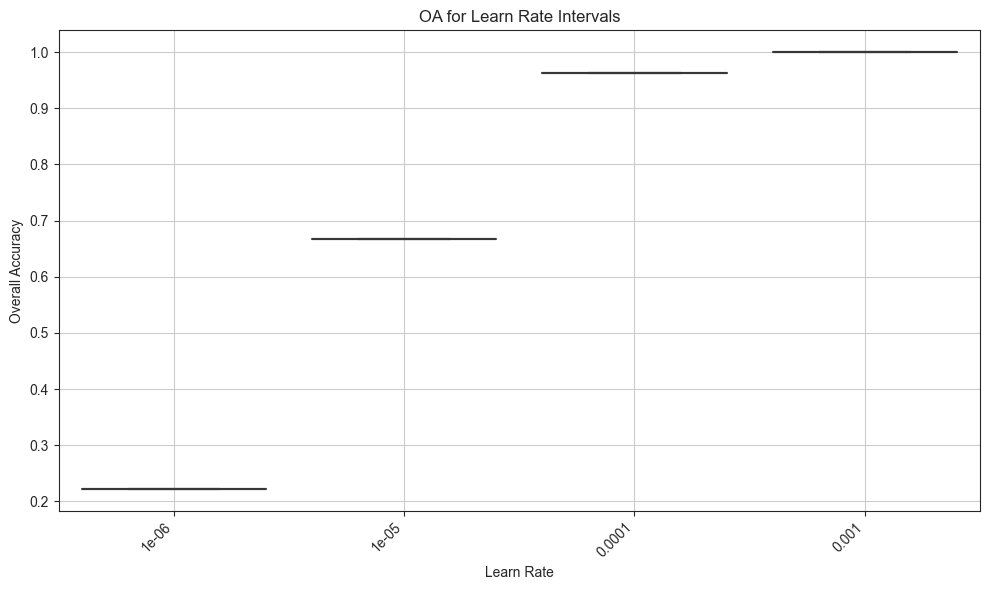

In [18]:
import seaborn as sns

wine_results = pd.DataFrame(results, columns=['Learn Rate', 'Accuracy'])

#visualising the results table
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.boxplot(x='Learn Rate', y="Accuracy", data=wine_results, palette="viridis")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.xlabel("Learn Rate")
plt.ylabel("Overall Accuracy")
plt.title("OA for Learn Rate Intervals")
plt.tight_layout()
plt.show()

In [20]:
#cells following this were an earlier version for debugging/double checking test cases

X = data.drop(columns=['class']).values
Y = data['class'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=451) 

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.int64)

In [25]:
epochs = 10

optimiser = optim.Adam(wine_model.parameters(), lr=0.001) #standard learning rate
loss_func = nn.CrossEntropyLoss()

wine_model = MLP(X_train_tensor)

#standard pytorch training block
for epoch in range(epochs):
    wine_model.train()
    optimiser.zero_grad()
    
    outputs = wine_model(X_train_tensor)
    loss = loss_func(outputs, Y_train_tensor)
    
    loss.backward()
    optimiser.step()
    
    #displays epoch/loss for monitoring in training 
    if (epoch + 1) % 10 == 0:
        formatted_epoch = epoch + 1
        formatted_loss = loss_func(outputs, Y_train_tensor)
        print(f"Epoch [{formatted_epoch}/{epochs}], Loss: {formatted_loss:.4f}")

Epoch [1/10], Loss: 1.1004
Epoch [2/10], Loss: 1.1004
Epoch [3/10], Loss: 1.1004
Epoch [4/10], Loss: 1.1004
Epoch [5/10], Loss: 1.1004
Epoch [6/10], Loss: 1.1004
Epoch [7/10], Loss: 1.1004
Epoch [8/10], Loss: 1.1004
Epoch [9/10], Loss: 1.1004
Epoch [10/10], Loss: 1.1004


In [26]:
wine_model.eval()
with torch.no_grad():
    test_outputs = wine_model(X_test_tensor)
    
    _, test_predictions = torch.max(test_outputs, 1)
    accuracy = torch.mean((test_predictions == Y_test_tensor).float())
    print("Test accuracy:", accuracy.item())

Test accuracy: 0.5


In [27]:
#train/test example result tuples
results = [(0.99, 0.327), (0.98, 0.645), (0.97, 0.912), 
                   (0.96, 0.936), (0.95, 0.947), (0.94, 0.934), 
                   (0.93, 0.945), (0.92, 0.969), (0.91, 0.956), 
                   (0.90, 0.962), (0.85, 0.986), (0.80, 0.993), 
                   (0.75, 0.985), (0.70, 0.991), (0.65, 0.991)]

#create a df from the results
wine_results = pd.DataFrame(results, columns=['Train %', 'OA'])

wine_results

,Train %,OA
0,0.99,0.327
1,0.98,0.645
2,0.97,0.912
3,0.96,0.936
4,0.95,0.947
5,0.94,0.934
6,0.93,0.945
7,0.92,0.969
8,0.91,0.956
9,0.90,0.962
